# Data Visualization

## Objectives

* Business Requirements 1:
    * The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

* inputs/cherryleaves_database/cherry-leaves/train
* inputs/cherryleaves_database/cherry-leaves/validation
* inputs/cherryleaves_database/cherry-leaves/test

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* A plot to visually distinguish the contrast between healthy leaf images and those infected with powdery mildew.
* Generate code that answers business requirement 1 and can be used to build image montage on Streamlit dashboard.

## Additional Comments




---

# Set Data Directory

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Set working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/my-fifth-project')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/my-fifth-project'

### Set input directories

* Set train, validation and test paths:

In [5]:
my_data_dir = 'inputs/cherryleaves_database/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are',labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data visualisation of image data

### Image shape & Preprocessing Images for Enhanced Data Visualization

This data visualization task involves computing the average size of images in the training set of a dataset. Image size is a crucial metric in image processing and computer vision tasks as it provides insights into the resolution and dimensions of the images. By calculating the average size of images in the training set, we gain a better understanding of the typical dimensions of the images in the dataset, which can be essential for various preprocessing and modeling tasks.

* Images size for training the model after resizing:

In [8]:
from PIL import Image
import shutil

# Set new target size
target_size = (200, 200)

# Set the paths
my_data_dir = 'inputs/cherryleaves_database/cherry-leaves'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')

# Resize images and remove old ones
def resize_images_and_remove_old(folder_path):
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for image_filename in os.listdir(label_path):
            img_path = os.path.join(label_path, image_filename)
            img = Image.open(img_path)
            resized_img = img.resize(target_size, resample=Image.BILINEAR)
            resized_img.save(img_path)  # Overwrite the old image with the new size
    # Remove old-sized images
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for image_filename in os.listdir(label_path):
            img_path = os.path.join(label_path, image_filename)
            img = Image.open(img_path)
            img_shape = img.size  # Check image size
            if img_shape != target_size:  # If size is not correct, delete the image
                os.remove(img_path)

# Train folder
resize_images_and_remove_old(train_path)

# Validation folder
resize_images_and_remove_old(val_path)

# Test folder
resize_images_and_remove_old(test_path)

* Analysis of image dimensions in the dataset, visualizing height and width distribution:

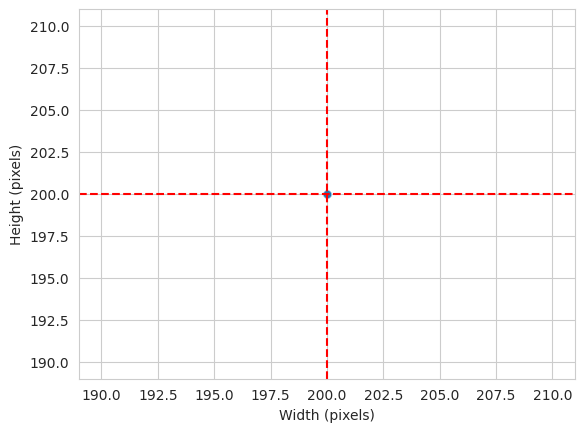

Width average: 200 
Height average: 200


In [9]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

The scatterplot of the images showed that all the images are the same size, there is no difference between them.

* Images size for training the model is the average from all image in train set:

In [10]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(200, 200, 3)

* Save the image shape embeddings:

In [11]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

### Average and variability of images per label

* Function to load images in an array:

In [12]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 20):
    """
    Loads images from the specified directory and resizes them to the given dimensions.

    """
    
    # Initialize empty arrays to store image data and labels
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    
    # Get the list of labels in the data directory
    labels = os.listdir(my_data_dir)

    # Loop through each label to load images
    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < n_images_per_label:
                img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                
                # Convert the image to a numpy array and normalize pixel values to [0, 1] range
                if image.img_to_array(img).max() > 1: 
                    img_resized = image.img_to_array(img) / 255
                else: 
                    img_resized = image.img_to_array(img)
                
                # Append the resized image and its corresponding label to the arrays
                X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

* Load image shape and labels in array:

In [13]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                          n_images_per_label = 30)
print(X.shape, y.shape)

(60, 200, 200, 3) (60,)


* Plot and save mean and variability of images per label:

In [14]:
def plot_mean_variability_per_labels(X, y, figsize=(10,5), save_image=False):
  """
  This function plots the average and variability images for each unique label in the dataset.

  Parameters:
  - X (numpy.ndarray): Array containing the image data.
  - y (numpy.ndarray): Array containing the corresponding labels for the images.
  - figsize (tuple): Size of the figure. Default is (10,5).
  - save_image (bool): Whether to save the generated images. Default is False.
  """
  
  for label_to_display in np.unique(y):
    # Capitalize label names and remove underscores
    formatted_label = label_to_display.capitalize().replace('_', ' ')

    sns.set_style("white")

    # Subset array for the current label
    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    # Calculate mean and standard deviation
    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    
    # Print label and image shape
    print(f"==== Label {formatted_label} ====")
    print(f"Image Shape: {avg_img.shape}")

    # Create subplots for average and variability images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for Label {formatted_label}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability Image for Label {formatted_label}")
    axes[1].imshow(std_img, cmap='gray')

    # Save or display the plots
    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

==== Label Healthy ====
Image Shape: (200, 200, 3)
==== Label Powdery mildew ====
Image Shape: (200, 200, 3)


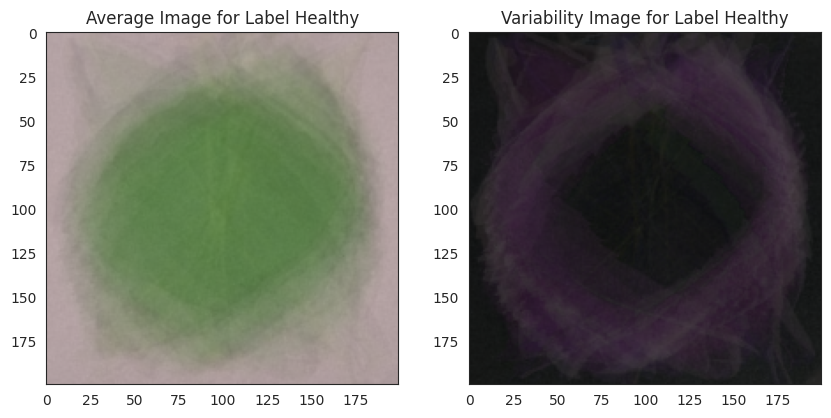

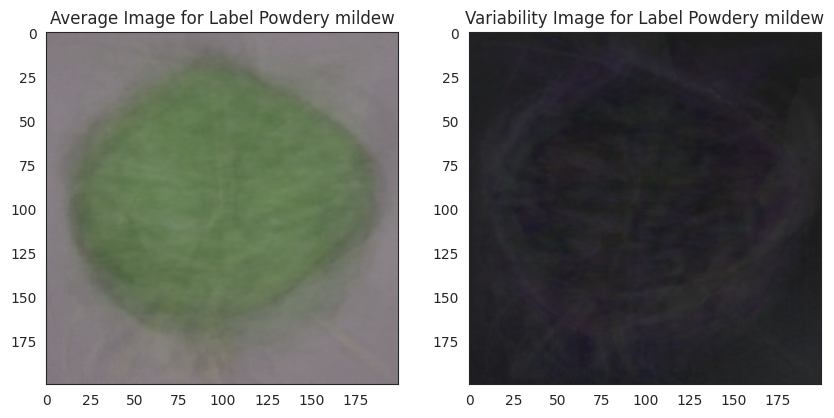

In [15]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(10,5),save_image=True)

---

### Difference between average healthy and average powdery-mildew infected cherry leaves:

In [16]:
def subset_image_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(16,5), save_image=False):
    """
    This function calculates the difference between the average images of two specified labels in the dataset and displays the result.

    """
    sns.set_style("white")

    # Format label names for display
    label_1_display = label_1.capitalize()
    label_2_display = label_2.capitalize().replace('_', ' ')

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} are not in {np.unique(y)} ")
        return

    # Calculate mean image for label 1
    images_label_1 = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label_1, axis=0)

    # Calculate mean image for label 2
    images_label_2 = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label_2, axis=0)

    # Calculate difference image
    difference_mean = label1_avg - label2_avg

    # Plot average images and difference image
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1_display}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2_display}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference Image: Avg {label_1_display} & {label_2_display}')

    # Save or display the plot
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


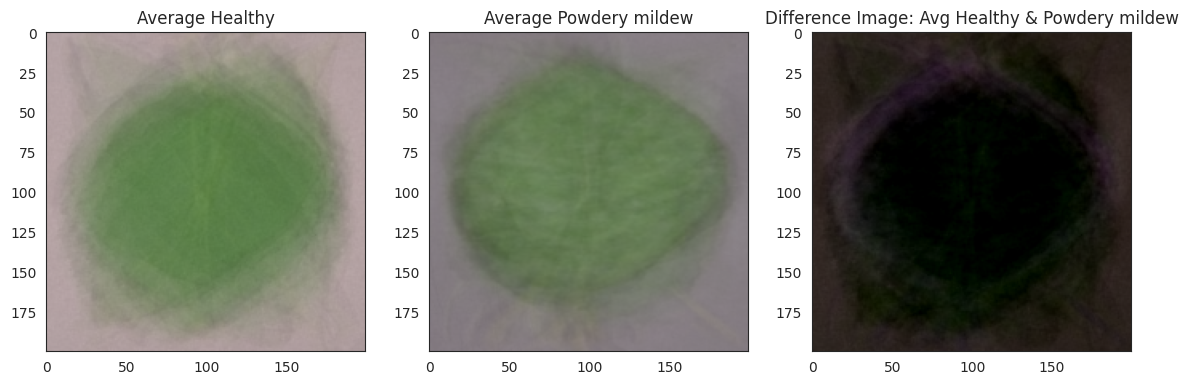

In [17]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(14,10),
                                        save_image=True
                                        )

---

### Image Montage

In [18]:
import itertools
import random
sns.set_style("white")

# logic
# if label exists in the folder
  # check if your montage space is greater tha nsubset size
  # create list of axes indices based on nrows and ncols
  # create a Figure and display images
    # in this loop, load and plot given image


def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(14,8)):
  

  labels = os.listdir(dir_path)

  # subset the class you are interested to display
  if label_to_display in labels:

    # checks if your montage space is greater than subset size
    images_list = os.listdir(dir_path+'/'+ label_to_display)
    if nrows * ncols < len(images_list):
      img_idx = random.sample(images_list, nrows * ncols)
    else:
      print(
          f"Decrease nrows or ncols to create your montage. \n"
          f"There are {len(images_list)} in your subset. "
          f"You requested a montage with {nrows * ncols} spaces")
      return
    

    # create list of axes indices based on nrows and ncols
    list_rows= range(0,nrows)
    list_cols= range(0,ncols)
    plot_idx = list(itertools.product(list_rows,list_cols))


    # create a Figure and display images
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)
    for x in range(0,nrows*ncols):
      img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
      img_shape = img.shape
      axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
      axes[plot_idx[x][0], plot_idx[x][1]].set_title
      axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
      axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
    plt.tight_layout()
    plt.show()


  else:
    print("The label you selected doesn't exist.")
    print(f"The existing options are: {labels}")

* Run Montage in all labels.

healthy


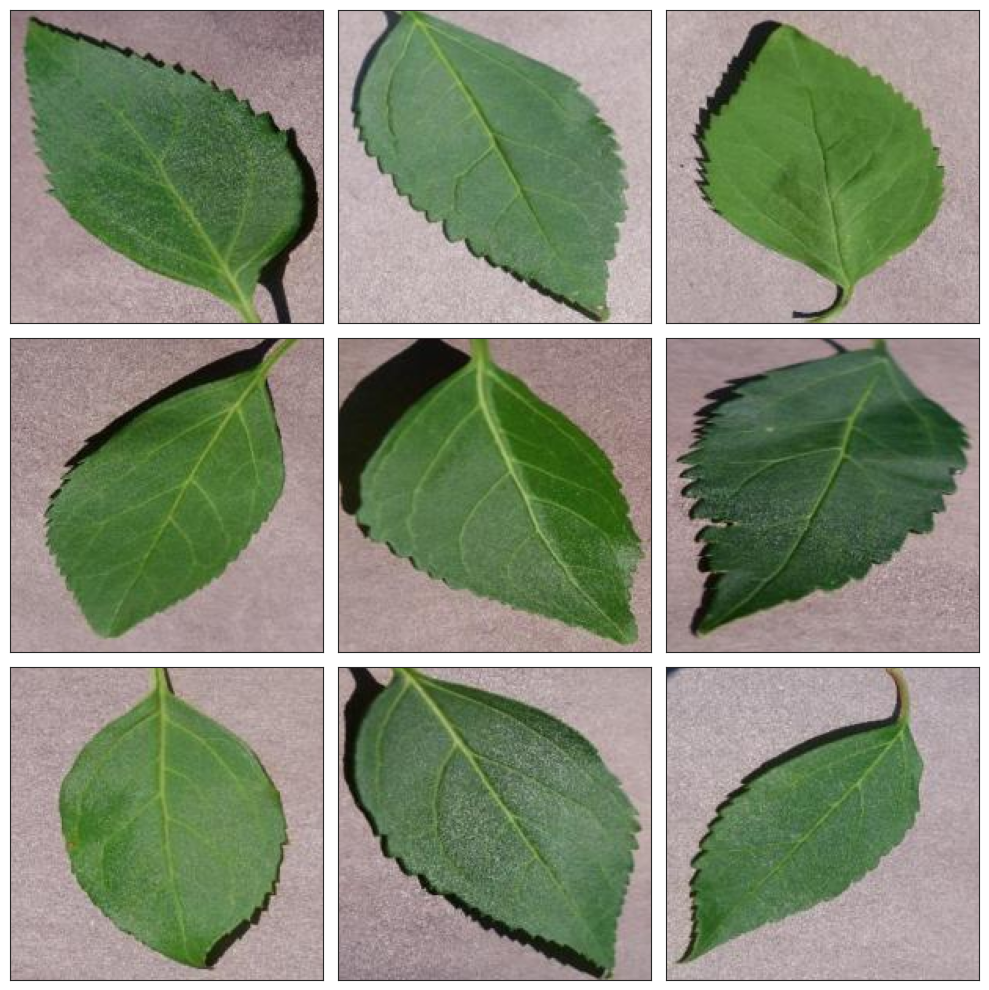



powdery_mildew


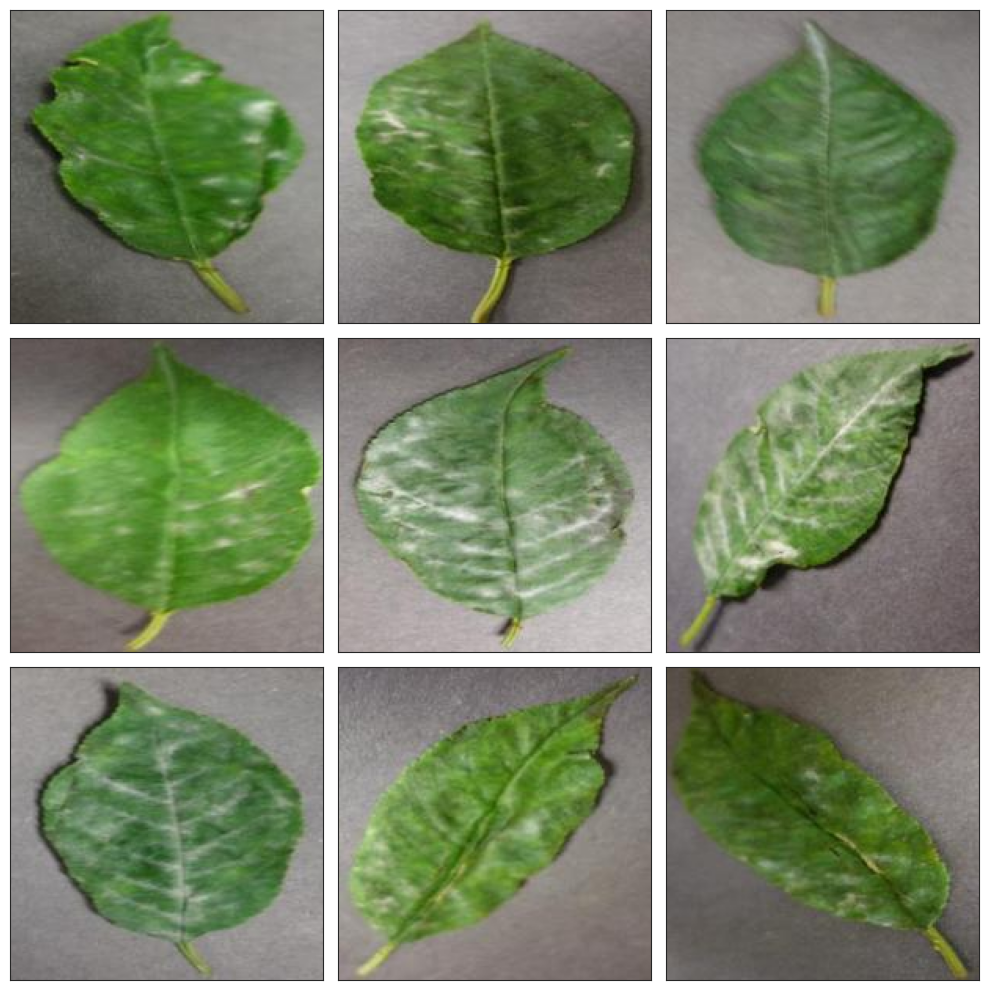

In [19]:
for label in labels:
  print(label)
  image_montage(dir_path= train_path,
                label_to_display= label,
                nrows=3, ncols=3,
                figsize=(10,10)
                )
  print("\n")